# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DQN

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_Restrict_TradeEnv

folder_path = f"result/rl-restrict-thres"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [5]:
best_params

{'OPEN_THRE': 1.6,
 'CLOS_THRE': 0.4,
 'period': 900,
 'verbose': 0,
 'prefix': 'Gridsearch',
 'kellycriterion': False,
 'fixed_amount': 0.1}

In [3]:
df.tail(10)

,time,close0,itvl,datetime,close1,spread,zscore
521369,1703818259999,0.000026,1m,2023-12-29 02:50:59.999,0.000028,-0.000002,0.083267
521370,1703818319999,0.000026,1m,2023-12-29 02:51:59.999,0.000028,-0.000002,0.082584
521371,1703818379999,0.000026,1m,2023-12-29 02:52:59.999,0.000028,-0.000002,0.063342
521372,1703818439999,0.000026,1m,2023-12-29 02:53:59.999,0.000028,-0.000002,0.088554
521373,1703818499999,0.000026,1m,2023-12-29 02:54:59.999,0.000028,-0.000002,0.086473
521374,1703818559999,0.000026,1m,2023-12-29 02:55:59.999,0.000028,-0.000002,0.224487
521375,1703818619999,0.000026,1m,2023-12-29 02:56:59.999,0.000028,-0.000002,0.257121
521376,1703818679999,0.000026,1m,2023-12-29 02:57:59.999,0.000028,-0.000002,0.291488
521377,1703818739999,0.000026,1m,2023-12-29 02:58:59.999,0.000028,-0.000002,0.536032
521378,1703818799999,0.000026,1m,2023-12-29 02:59:59.999,0.000028,-0.000002,1.049747


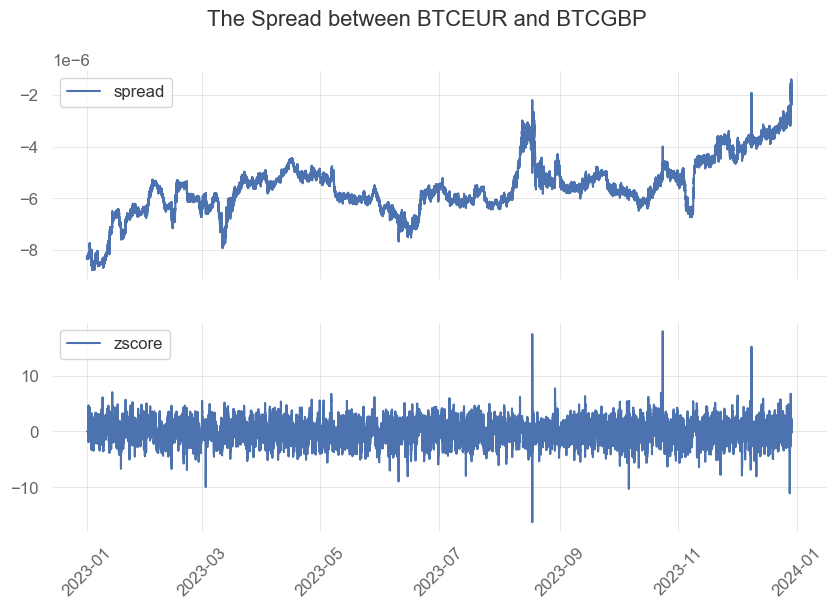

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period']) * 0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 87840


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_Restrict_TradeEnv(train)
obs, _ = env.reset()
check_env(env)

Tensorboard

## Train the Model with Trading Env

In [7]:
log_path = f"logs/restrict_thres/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres/A2C_1
Deleted: logs/restrict_thres/DQN_1
Deleted: logs/restrict_thres/PPO_1


In [8]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=True)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

Output()

In [9]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [10]:
'''DQN'''

model_dqn = DQN("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=max_train_len, progress_bar=True)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

Output()

## Create the Custom Test Env

In [11]:
test_env_ppo = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_dqn = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_dqn.csv", verbose=1)
test_env_expt = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [12]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 38475


## Test Env with Trained Model

In [13]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|          | 13/38475 [00:00<05:07, 124.94it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([0.9079923])}, action: 1, reward:1.0, networth: 1.0


 10%|█         | 3864/38475 [00:44<07:03, 81.69it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.48672361])}, action: 1, reward:1.0, networth: 1.0054


 20%|██        | 7712/38475 [01:21<04:39, 110.03it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.36188634])}, action: 1, reward:1.0, networth: 1.0082


 30%|███       | 11560/38475 [01:56<04:05, 109.54it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.17013337])}, action: 1, reward:1.0, networth: 1.0193


 40%|████      | 15405/38475 [02:31<03:35, 106.81it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60360645])}, action: 1, reward:1.0, networth: 1.0289


 50%|█████     | 19260/38475 [03:06<02:51, 112.18it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.91359769])}, action: 1, reward:1.0, networth: 1.0404


 60%|██████    | 23102/38475 [03:42<02:19, 110.55it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.58071076])}, action: 1, reward:1.0, networth: 1.0532


 70%|███████   | 26949/38475 [04:17<01:49, 105.74it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11167536])}, action: 1, reward:1.0, networth: 1.0708


 80%|████████  | 30797/38475 [04:53<01:11, 107.78it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.48294856])}, action: 1, reward:1.0, networth: 1.0917


 90%|█████████ | 34638/38475 [05:29<00:34, 109.79it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27726955])}, action: 1, reward:1.0, networth: 1.107


100%|██████████| 38475/38475 [06:04<00:00, 105.49it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.43874295])}, action: 1, reward:1.0, networth: 1.1315
Finished
networth: 1.1315583966328386


In [14]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

  0%|          | 17/38475 [00:00<04:02, 158.75it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([0.9079923])}, action: 1, reward:1.0, networth: 1.0


 10%|█         | 3862/38475 [00:45<07:01, 82.14it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.48672361])}, action: 1, reward:1.0, networth: 1.0013


 20%|██        | 7704/38475 [01:23<04:45, 107.92it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.36188634])}, action: 1, reward:1.0, networth: 1.0067


 30%|███       | 11556/38475 [02:00<04:08, 108.27it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.17013337])}, action: 1, reward:1.0, networth: 1.0117


 40%|████      | 15409/38475 [02:37<03:37, 106.01it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60360645])}, action: 1, reward:1.0, networth: 1.0155


 50%|█████     | 19258/38475 [03:13<02:58, 107.70it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.91359769])}, action: 1, reward:1.0, networth: 1.0266


 60%|██████    | 23102/38475 [03:50<02:23, 107.29it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.58071076])}, action: 1, reward:1.0, networth: 1.0291


 70%|███████   | 26950/38475 [04:27<01:50, 104.76it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11167536])}, action: 1, reward:1.0, networth: 1.036


 80%|████████  | 30786/38475 [05:05<01:14, 103.24it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.48294856])}, action: 1, reward:1.0, networth: 1.0496


 90%|█████████ | 34639/38475 [05:42<00:35, 107.15it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27726955])}, action: 1, reward:1.0, networth: 1.056


100%|██████████| 38475/38475 [06:19<00:00, 101.45it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-1.43874295])}, action: 1, reward:1.0, networth: 1.0753
Finished
networth: 1.075280607840424


In [15]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
except OSError:
    pass

obs, _ = test_env_dqn.reset()

for i in trange(max_test_len):
    action, _states = model_dqn.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_dqn.step(action)
    if i%int(max_test_len/10)==0:
        test_env_dqn.render()

test_env_dqn.close()

  0%|          | 15/38475 [00:00<04:29, 142.86it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([0.9079923])}, action: 1, reward:1.0, networth: 1.0


 10%|█         | 3862/38475 [00:37<06:06, 94.36it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.48672361])}, action: 1, reward:1.0, networth: 1.0073


 20%|██        | 7713/38475 [01:10<04:05, 125.53it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.36188634])}, action: 1, reward:1.0, networth: 1.0073


 30%|███       | 11558/38475 [01:42<03:37, 123.59it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.17013337])}, action: 1, reward:1.0, networth: 1.0229


 40%|████      | 15407/38475 [02:13<03:12, 119.93it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60360645])}, action: 1, reward:1.0, networth: 1.0316


 50%|█████     | 19251/38475 [02:45<02:34, 124.30it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.91359769])}, action: 0, reward:1.0, networth: 1.0409


 60%|██████    | 23100/38475 [03:16<02:07, 120.60it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.58071076])}, action: 1, reward:1.0, networth: 1.0519


 70%|███████   | 26946/38475 [03:48<01:29, 128.14it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.11167536])}, action: 1, reward:1.0, networth: 1.0663


 80%|████████  | 30789/38475 [04:20<01:00, 127.57it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.48294856])}, action: 0, reward:1.0, networth: 1.0833


 90%|█████████ | 34638/38475 [04:52<00:31, 120.94it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.27726955])}, action: 1, reward:1.0, networth: 1.0976


100%|██████████| 38475/38475 [05:23<00:00, 118.79it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-1.43874295])}, action: 2, reward:1.0, networth: 1.1258
Finished
networth: 1.1258707068196332


## Also run randomly generated actions

In [16]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

  0%|          | 15/38475 [00:00<04:24, 145.63it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([0.9079923])}, action: 0, reward:0.0, networth: 1.0


 10%|█         | 3855/38475 [00:48<10:08, 56.92it/s] 

signal: {'position': 2, 'zone': 1, 'zscore': array([0.48672361])}, action: 1, reward:1.002, networth: 1.0065


 20%|██        | 7720/38475 [01:19<03:17, 156.05it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([1.36188634])}, action: 2, reward:0.0, networth: 1.0131


 30%|███       | 11575/38475 [01:43<02:40, 167.92it/s]

signal: {'position': 0, 'zone': 2, 'zscore': array([-0.17013337])}, action: 0, reward:0.0, networth: 1.0068


 40%|████      | 15417/38475 [02:06<02:19, 165.45it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([0.60360645])}, action: 2, reward:0.0, networth: 1.0096


 50%|█████     | 19262/38475 [02:30<01:58, 162.13it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([0.91359769])}, action: 1, reward:0.004, networth: 1.0015


 60%|██████    | 23109/38475 [02:53<01:32, 166.71it/s]

signal: {'position': 2, 'zone': 1, 'zscore': array([0.58071076])}, action: 2, reward:0.0, networth: 1.0007


 70%|███████   | 26953/38475 [03:17<01:07, 170.06it/s]

signal: {'position': 2, 'zone': 2, 'zscore': array([0.11167536])}, action: 1, reward:1.004, networth: 1.0026


 80%|████████  | 30801/38475 [03:41<00:47, 161.04it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([1.48294856])}, action: 0, reward:0.0, networth: 1.0057


 90%|█████████ | 34659/38475 [04:05<00:23, 162.10it/s]

signal: {'position': 0, 'zone': 2, 'zscore': array([-0.27726955])}, action: 2, reward:0.0, networth: 1.0241


100%|██████████| 38475/38475 [04:28<00:00, 143.07it/s]

signal: {'position': 2, 'zone': 3, 'zscore': array([-1.43874295])}, action: 2, reward:1.0, networth: 1.0203
Finished
networth: 1.0202425473357797


### Analyze with Quanstats

In [17]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-12-28 08:15:59.999000', '1.075280607840424']
The ending capital of networth_dqn.csv is ['2023-12-28 08:15:59.999000', '1.1258707068196332']
The ending capital of networth_ppo.csv is ['2023-12-28 08:15:59.999000', '1.1315583966328386']
The best model is networth_ppo.csv


In [18]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Compound annual growth rate: 468%
Total orders count: 38474
Total long action: 4269
Total short action: 5575
Won orders count: 762
Lost orders count: 90
Win/Loss order ratio: 8.466666666666667
Max win: 0.0020551164408606493
Max Loss: -0.0009358441083475721
Avg order pnl: 3.419410423476598e-06
Avg order pnl won: 0.00018483753833620366
Avg order pnl lost: -0.00010319786199276167


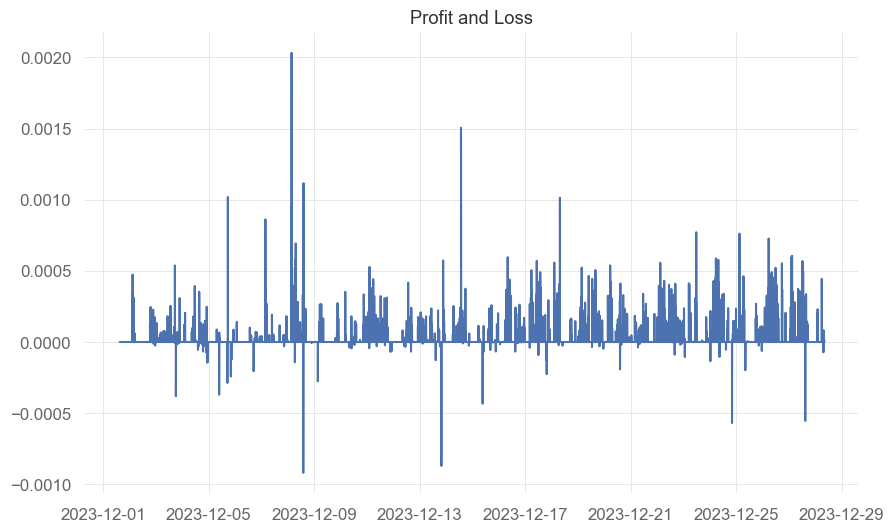

In [19]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-12-01
End Period                 2023-12-28
Risk-Free Rate             0.0%
Time in Market             3.0%

Cumulative Return          13.16%
CAGR﹪                     231.32%

Sharpe                     1.42
Prob. Sharpe Ratio         100.0%
Smart Sharpe               1.41
Sortino                    5.47
Smart Sortino              5.43
Sortino/√2                 3.87
Smart Sortino/√2           3.84
Omega                      14.91

Max Drawdown               -0.09%
Longest DD Days            1
Volatility (ann.)          0.06%
Calmar                     2517.29
Skew                       15.5
Kurtosis                   535.67

Expected Daily %           0.0%
Expected Monthly %         13.16%
Expected Yearly %          13.16%
Kelly Criterion            83.44%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.01%
Expected Shortfall (cVaR)  -0.01%

Max Consecutive Wins   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-12-08,2023-12-08,2023-12-08,1,-0.091894,NaN
2,2023-12-13,2023-12-13,2023-12-13,1,-0.090083,-0.032822
3,2023-12-04,2023-12-05,2023-12-05,1,-0.061788,-0.042800
4,2023-12-24,2023-12-24,2023-12-24,1,-0.056908,-0.055836
5,2023-12-27,2023-12-27,2023-12-27,1,-0.055391,-0.021700


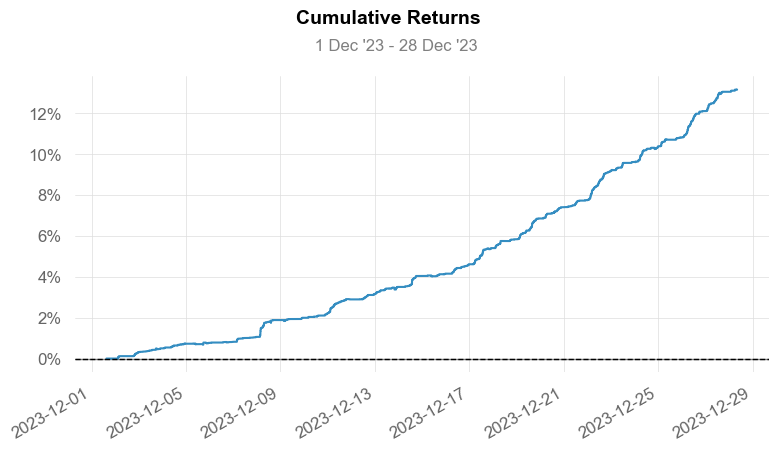

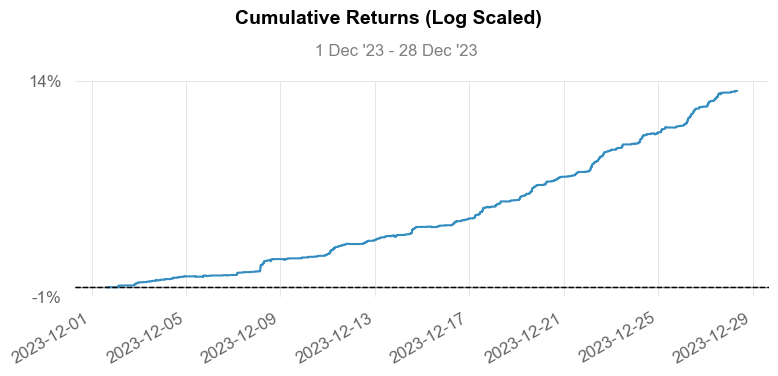

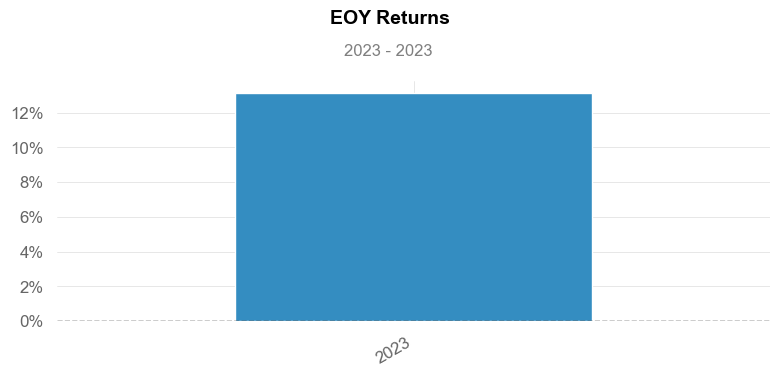

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


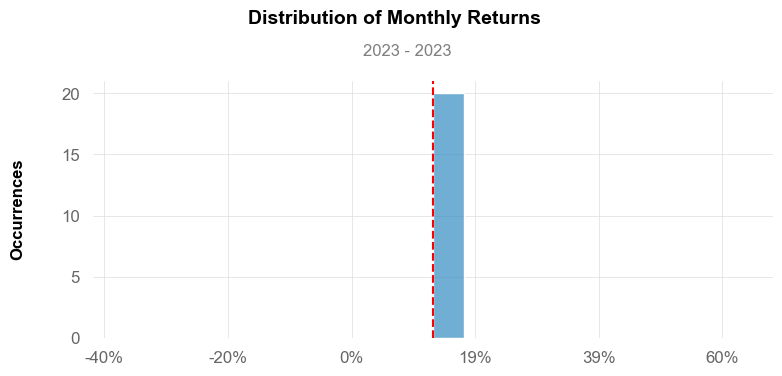

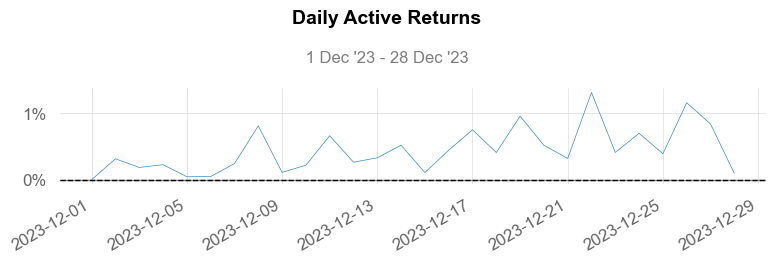

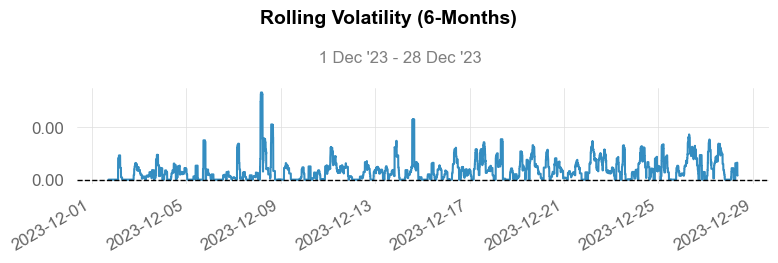

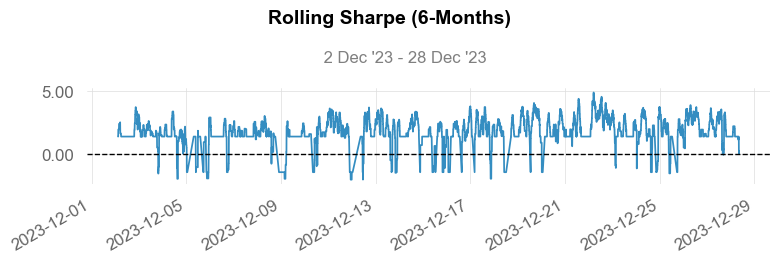

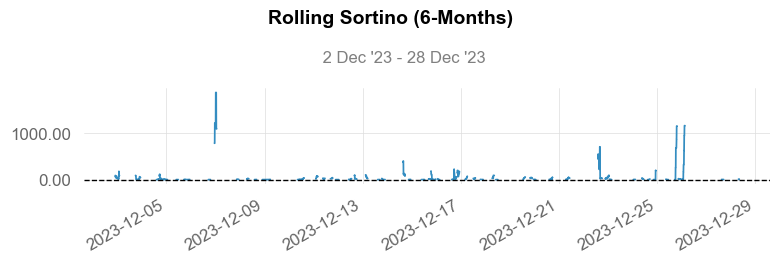

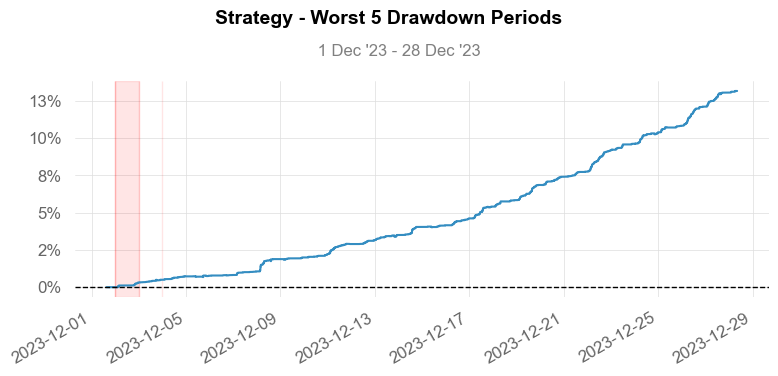

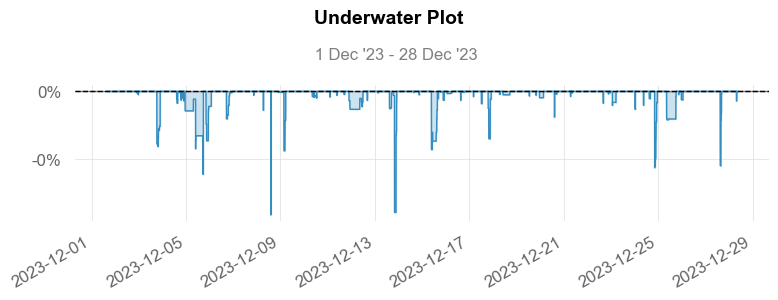

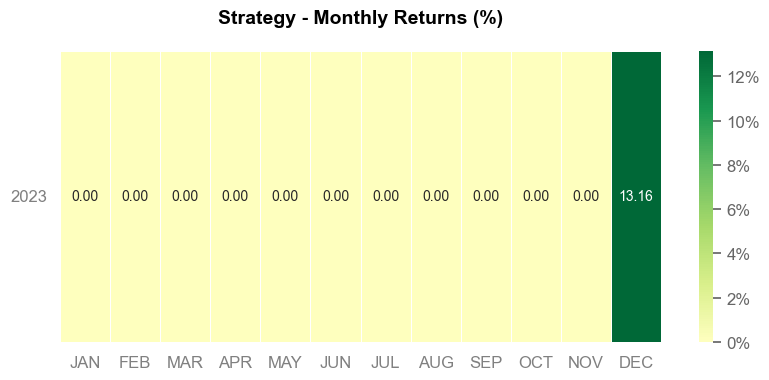

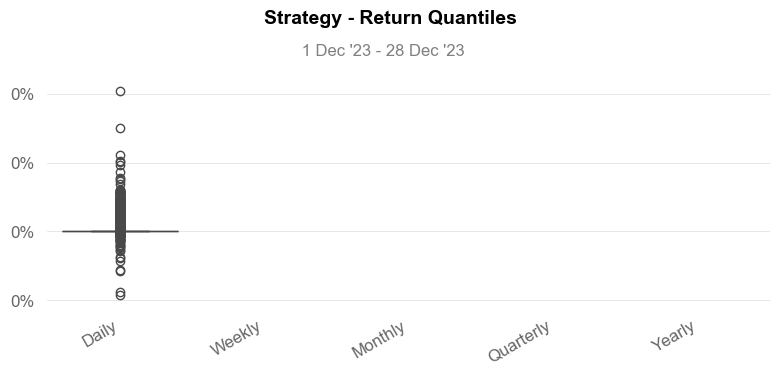

In [20]:
qs.reports.full(best_return['returns'])